In [2]:
FN = 'vocabulary-embedding'

In [3]:
seed=42
vocab_size=40000
embedding_dim=100
lower=True


import pickle



import json

data = []
i=0
with open('sample-1M.jsonl') as f:
    for line in f:
        data.append(json.loads(line))
        i=i+1
        if i>10000:
            break
    
f.close()

In [4]:
print (data[1])


{'published': '2015-09-17T15:00:00Z', 'source': 'Virtualization Conference & Expo', 'title': 'Jumpshot Gives Marketers Renewed Visibility Into Paid and Organic Keywords With Launch of Jumpshot Elite', 'content': 'New Product Gives Marketers Access to Real Keywords, Conversions and Results Along With 13 Months of Historical Data \n\nSAN FRANCISCO, CA -- (Marketwired) -- 09/17/15 -- Jumpshot, a marketing analytics company that uses distinctive data sources to paint a complete picture of the online customer journey, today announced the launch of Jumpshot Elite, giving marketers insight into what their customers are doing the 99% of the time they\'re not on your site. For years, marketers have been unable to see what organic and paid search terms users were entering, much less tie those searches to purchases. Jumpshot not only injects that user search visibility back into the market, but also makes it possible to tie those keywords to conversions -- for any web site. \n\n"Ever since search

In [5]:

titles=[]
descs=[]
for article in data:
    titles.append(article['title'])
    descs.append(article['content'])
print(descs[2])    
    
    

GoogleFacebookTwitter


In [6]:
titles


['Worcester breakfast club for veterans gives hunger its marching orders',
 'Jumpshot Gives Marketers Renewed Visibility Into Paid and Organic Keywords With Launch of Jumpshot Elite',
 'The Return Of The Nike Air Max Sensation Has 80’s Babies Hyped!',
 'This New Dating App Will Ruin Your Internet Game',
 'Pay up or face legal action: DBKL',
 'Euro up; USD, Pound and Yen down',
 'THE INFLUENCE OF OUR WORDS',
 "Hands on with Apple's iPhone 6s, iPad Pro and Apple TV",
 'Harwood Feffer LLP Announces Investigation of VASCO Data Security International, Inc.',
 'What will happen to Peta Credlin and Brian Loughnane, Liberal power couple?',
 '2015’s Opening Game Predictions',
 'Semtech (SMTC) Trading Near $17.29 Resistance Level',
 'New Hillary Clinton email chain discovered',
 'Former pitcher Andujar dies at 62',
 "Five key plays from Texas State's home opener",
 'Police chiefs warn ministers Were too broke to go on the beat',
 'MY TAKE ON THIS: Politicians should give us a break on empty prom

In [7]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount=Counter(w for txt in lst for w in txt.split())
    vocab = [word[0] for word in sorted(vocabcount.items(), key=lambda x: -x[1])]
    return vocab,vocabcount
vocab,vocabcount=get_vocab(titles+descs)


In [8]:
print(len(vocab))

289403


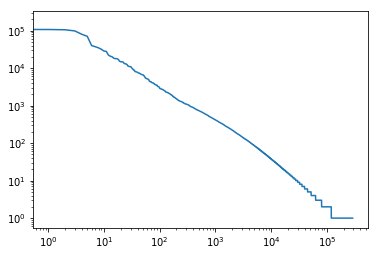

In [9]:
import matplotlib.pyplot as plt
plt.plot([vocabcount[word] for word in vocab])
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.show()

In [30]:
empty=0
eos=1
start_idx=eos+1

def get_idx(vocab,vocbcount):
    word2idx=dict((word,idx+start_idx) for idx,word in enumerate(vocab)) 
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    idx2word=dict((idx+start_idx,word) for idx,word in enumerate(vocab))
    idx2word[empty] ='<empty>'
    idx2word[eos] = '<eos>'
    return word2idx,idx2word
word2idx, idx2word = get_idx(vocab, vocabcount)
print(word2idx[idx2word[2]])


2


In [31]:
fname = 'glove.6B.%dd.txt'%embedding_dim
import os
datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join(datadir, fname)
if not os.path.exists(glove_name):
    print(glove_name)

In [32]:
glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = glove_n_symbols[0].split()[0]
glove_n_symbols

"'wc'"

In [33]:
import numpy as np
glove_index_dict={}
glove_embedding_weights=np.empty((400000,embedding_dim))
global_scale=0.1
with open(glove_name,'r',encoding='utf-8') as fp:
    i=0
    for l in fp:
        l=l.strip().split()
        w=l[0]
        glove_index_dict[w]=i
        glove_embedding_weights[i,:]=[float(j) for j in l[1:]]
        i+=1
glove_embedding_weights*=global_scale        
        

In [26]:
glove_embedding_weights.std()


0.040815727600190289

In [ ]:
index_dict = {}

print (glove_index_dict["completely"])
import six
for w,i in glove_index_dict.items():
    print(w)
   

In [35]:
import numpy as np


In [36]:
vocab_size=31100
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1

In [37]:
glove_thr = 0.5

word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

In [38]:

normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])

In [39]:
for orig, sub, score in glove_match[-10:]:
    print (score, orig,'=>', idx2word[sub])

0.500046990971 chiming => bells
0.500038817147 Crafters => creatives
0.500034362804 potshot => Dianabol
0.500028933919 Henshaw => Rousey
0.50002648825 biz => Showbiz
0.50002648825 Biz => Showbiz
0.50000921108 Freeland => Colton
0.500007485692 Pettibone => Bielema
0.500003821343 Irrevocable => acknowledgement
0.500003821343 irrevocable => acknowledgement


In [40]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)


In [41]:

Y = [[word2idx[token] for token in headline.split()] for headline in titles]
len(Y)

10001

In [42]:
X = [[word2idx[token] for token in d.split()] for d in descs]
len(X)

10001

KeyError: 'saluted'

In [43]:
import pickle
with open('%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)


In [44]:
with open('%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)